In [1]:
# Copyright 2025 Luke Moffett
# Licensed under the Apache License, Version 2.0

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch

from IPython.display import display
from clz_or_cls import analysis, datasets as corc_ds, analysis

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

plt.rcParams['figure.dpi'] = 300
pd.options.display.float_format = '{:,.1f}'.format
pd.set_option('display.max_rows', 200)
%matplotlib inline

# Perform Analysis

In [ ]:
csvs = analysis.get_prompt_recovery_csvs(skip_test=['repeated'])
len(csvs)

In [3]:
result_df = analysis.load_and_concatenate_csvs(csvs, levels=['model', 'size', 'xshot', 'train', 'test'])

result_df.head()

,Unnamed: 0,clean,perturbed,source,group,class,predicted,batch,model,size,xshot,train,test,legibility_score,legible
0,0,gamma,gamma',zeroe_phonetic,0.0,phonetic,gamma,0,chatgpt,gpt-3_5-turbo-0613,50-shot,phonetic,phonetic,NaN,NaN
1,1,nursing,nursinge,zeroe_phonetic,0.0,phonetic,nursing,0,chatgpt,gpt-3_5-turbo-0613,50-shot,phonetic,phonetic,NaN,NaN
2,2,twisted,ttwistted,phonee,0.0,phonetic,twisted,0,chatgpt,gpt-3_5-turbo-0613,50-shot,phonetic,phonetic,NaN,NaN
3,3,atom,ATM,anthro_phonetic,0.0,phonetic,ATM,0,chatgpt,gpt-3_5-turbo-0613,50-shot,phonetic,phonetic,NaN,NaN
4,4,sink,sinc,phonee,0.0,phonetic,sink,0,chatgpt,gpt-3_5-turbo-0613,50-shot,phonetic,phonetic,NaN,NaN


In [4]:
# Clean up response formatting errors from some models

result_df['predicted_raw'] = result_df['predicted']

# some models add commentary after the word quote, which was not parsed out during the initial runs
result_df['predicted'] = result_df['predicted'].apply(lambda s: s.split('"')[0] if type(s) == str and s.count('"') == 1 else s)

In [5]:
strategies = ['anthro_phonetic', 'anthro_typo', 'zeroe_typo', 'zeroe_noise', 'zeroe_phonetic', 'phonee', 'dces', 'ices', 'legit_extended']

all_test_df = pd.DataFrame()
for strategy in strategies:
    test_df = corc_ds.generated_df(strategy, split='test')

    test_df['strategy'] = strategy

    all_test_df = pd.concat([all_test_df, test_df])

all_test_df.drop_duplicates(['perturbed', 'strategy']).groupby('strategy').count()

,clean,perturbed,legibility_score,legible
strategy,,,,
anthro_phonetic,4776,4776,4776,0
anthro_typo,4111,4111,4111,0
dces,7560,7560,7560,0
ices,7713,7713,7713,0
legit_extended,7398,7398,7398,7102
phonee,6434,6434,0,0
zeroe_noise,7150,7150,7150,0
zeroe_phonetic,7443,7443,0,0
zeroe_typo,5300,5300,5300,0


In [6]:
result_df = result_df.merge(all_test_df[['perturbed', 'strategy']], on='perturbed')

In [7]:
result_df['setting'] = result_df.apply(lambda row: row['model'] + '-' + row['size'] if row['model'] not in ('chatgpt', 'palm2') else row['size'], axis=1)
result_df['setting'].head()

0    gpt-3_5-turbo-0613
1    gpt-3_5-turbo-0613
2    gpt-3_5-turbo-0613
3    gpt-3_5-turbo-0613
4    gpt-3_5-turbo-0613
Name: setting, dtype: object

In [11]:
def safe_match(predicted, clean):
    if type(predicted) != str or type(clean) != str:
        return False

    return predicted.lower() == clean.lower()

def nan_match(predicted, clean):
    """
    returns nan if predict is nan
    """
    if type(predicted) == float:
        return np.nan

    return safe_match(predicted, clean)

result_df['match'] = result_df.apply(lambda row: safe_match(row['predicted'], row['clean']), axis=1)
result_df['nan_match'] = result_df.apply(lambda row: nan_match(row['predicted'], row['clean']), axis=1)
result_df[['match', 'nan_match']].value_counts(normalize=True)

match  nan_match
False  False       0.5
True   True        0.5
dtype: float64

In [ ]:
from nltk.metrics.distance import edit_distance

result_df['pertubed_edit'] = result_df.apply(lambda row: edit_distance(row['perturbed'], row['clean']), axis=1)
result_df.hist('pertubed_edit', bins=[i for i in range(15)])

### Impact of Word Part

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')

In [15]:
from nltk import pos_tag

result_df['clean_pos'] = [t[1] for t in pos_tag(result_df['clean'])]
result_df.groupby('clean_pos').count()[['clean']]

,clean
clean_pos,
CC,2419
CD,3334
DT,24
FW,13772
IN,23653
JJ,393307
JJR,1979
JJS,7382
MD,3749


In [16]:
rows = []
for (setting, xshot, clean_pos), group in result_df.groupby(['setting', 'xshot', 'clean_pos']):
    group_values = group['match'].value_counts(normalize=True)
    t = group_values[True] if True in group_values else 0.0
    f = group_values[False] if False in group_values else 0.0
    rows.append((setting, xshot, clean_pos, len(group), t, f))

pos_df = pd.DataFrame(rows, columns=['setting', 'xshot', 'clean_pos', 'n', 'true_val', 'false_val']).set_index(['xshot', 'setting', 'clean_pos']).sort_index()
pos_df

n  true_val  false_val
xshot   setting        clean_pos                           
0-shot  falcon-40B     CC           14       0.4        0.6
                       FW            7       0.4        0.6
                       IN           55       0.7        0.3
                       JJ          964       0.6        0.4
                       JJS          23       0.4        0.6
...                                ...       ...        ...
50-shot text-bison-001 VBG        1795       0.7        0.3
                       VBN        1230       0.7        0.3
                       VBP         492       0.5        0.5
                       VBZ         342       0.6        0.4
                       WP           13       0.6        0.4

[433 rows x 3 columns]

In [17]:
pos_df.loc['0-shot'].reset_index()['setting'].unique()

array(['falcon-40B', 'falcon-7B', 'gpt-3_5-turbo-0301',
       'gpt-3_5-turbo-0613', 'gpt-4-1106-preview', 'llama2-13B',
       'llama2-70B', 'llama2-7B', 'mistral-7B', 'text-bison-001'],
      dtype=object)

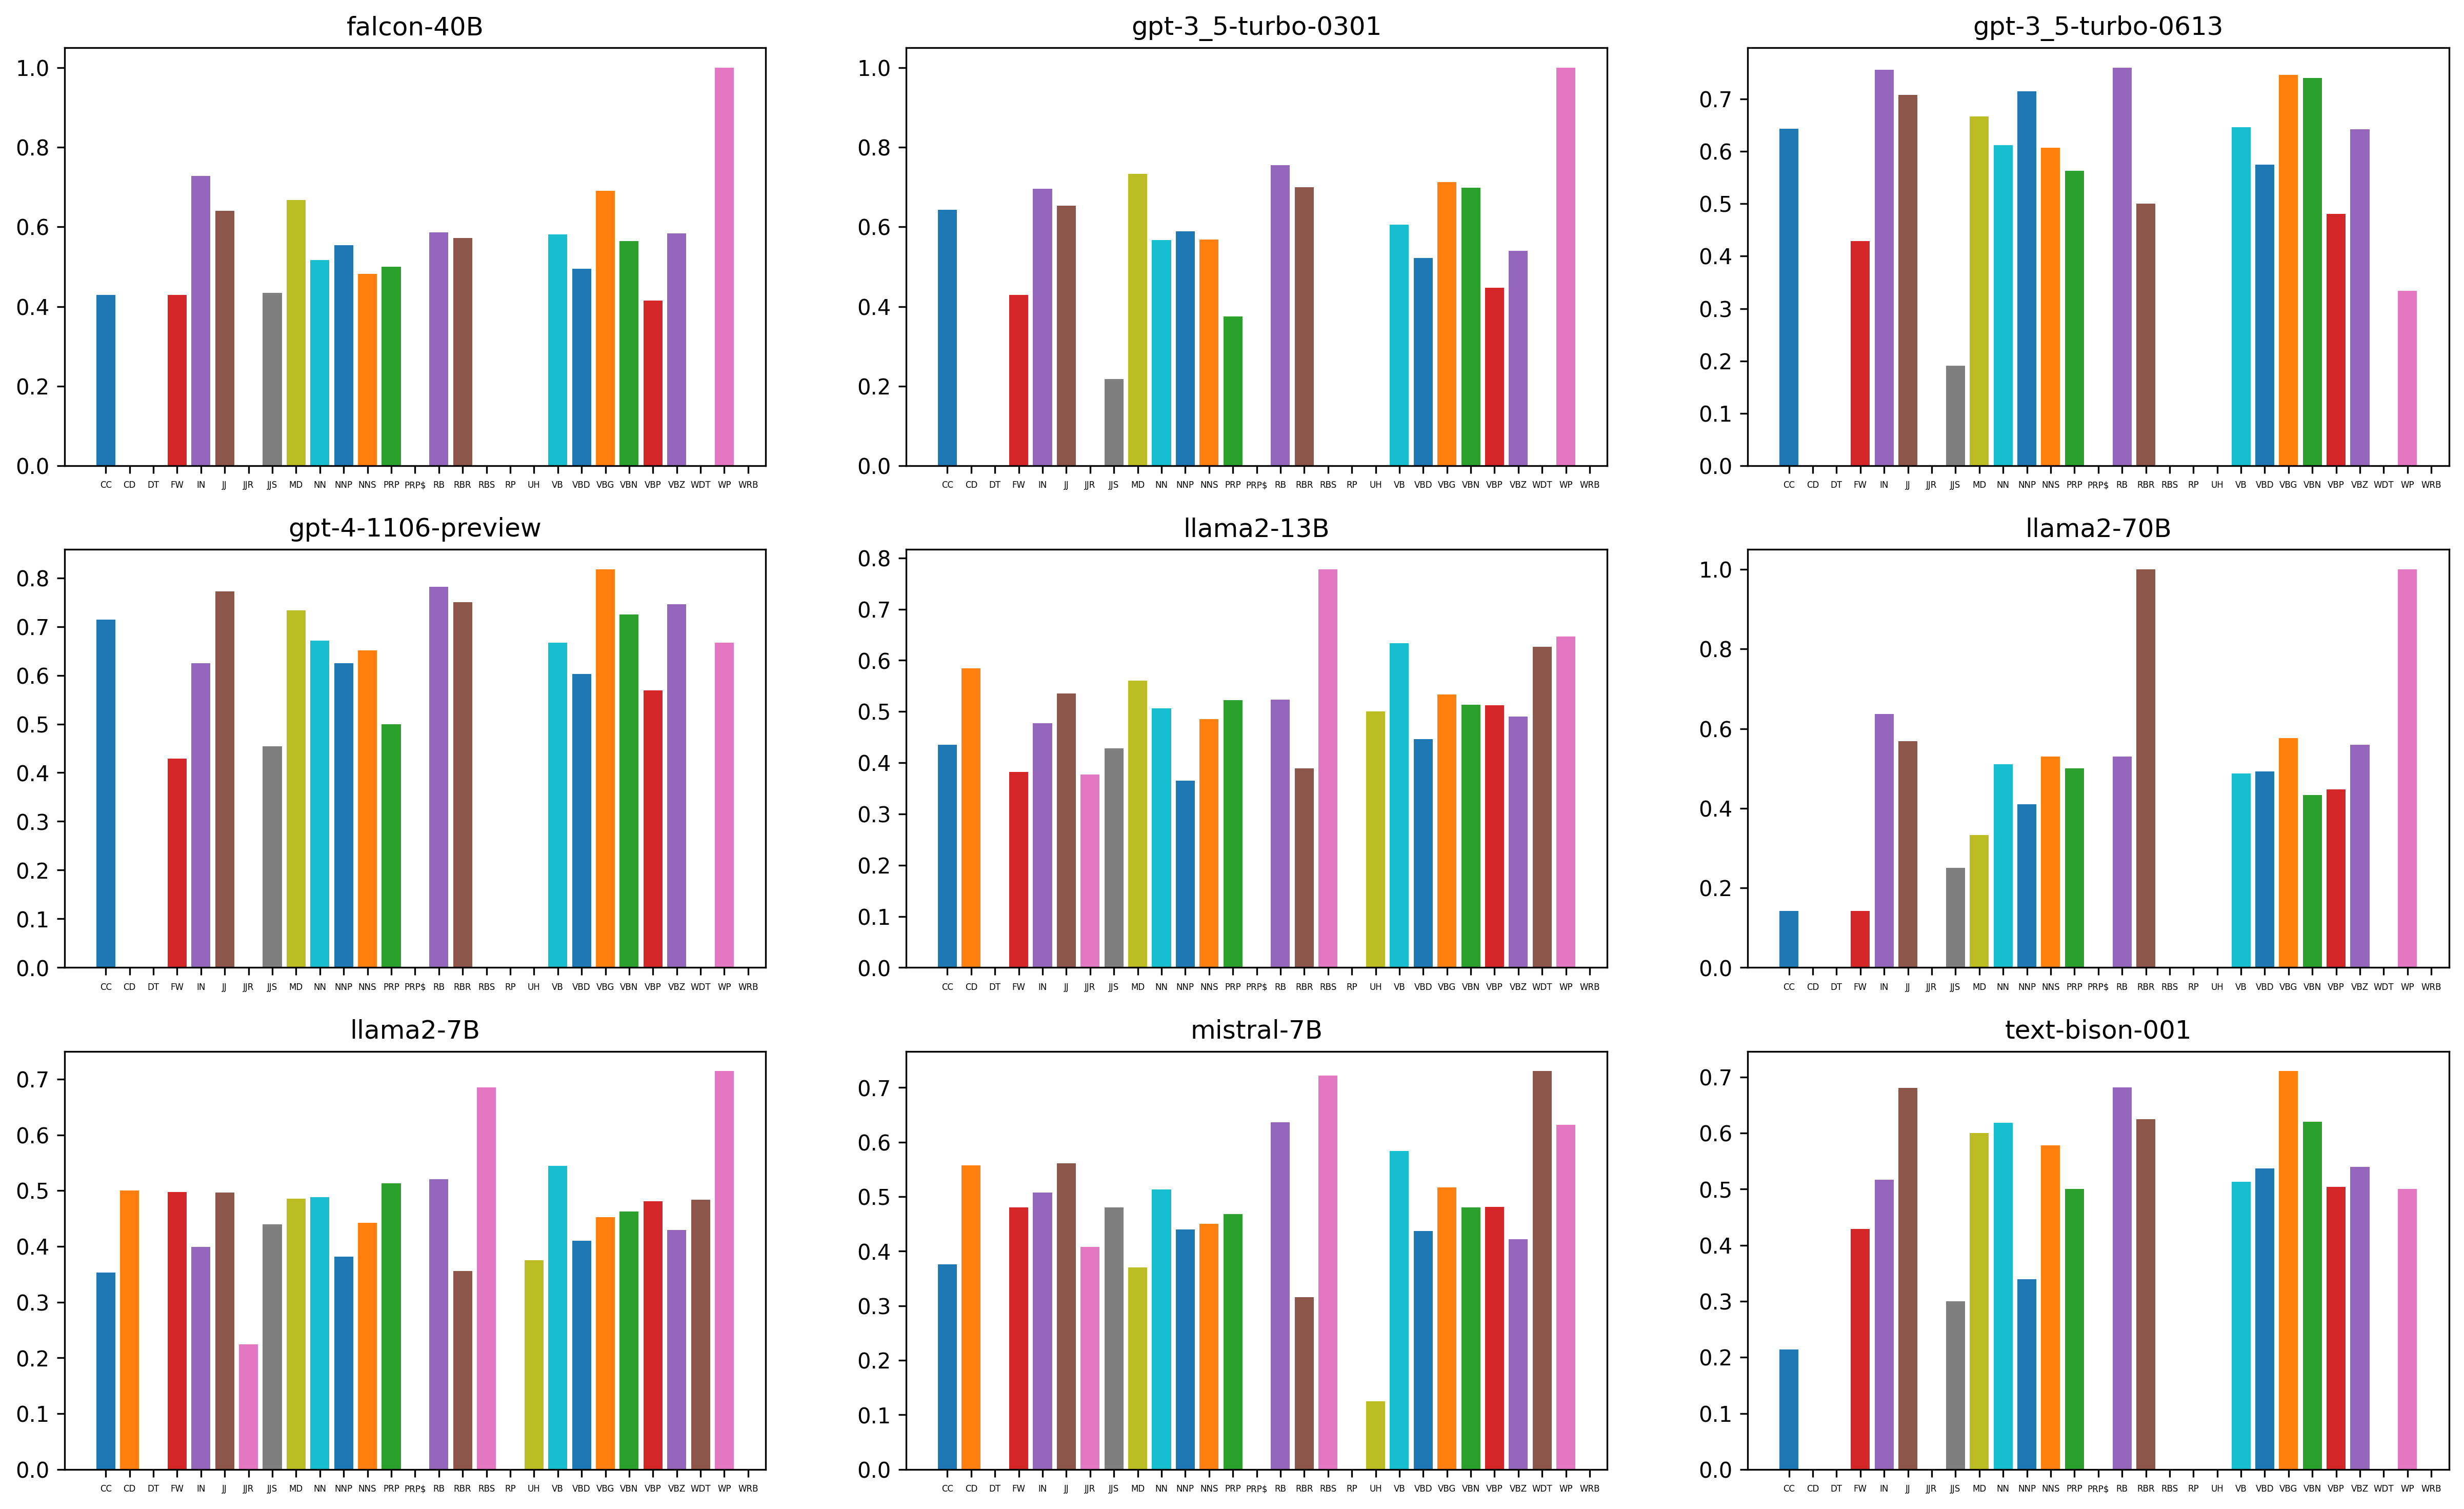

In [18]:
fig, axs = plt.subplots(3, 3, figsize=(20, 12))

all_pos = result_df['clean_pos'].sort_values().unique()
i_skip = 0

for i, (setting, group) in enumerate(pos_df.loc['0-shot'].groupby('setting')):
    if setting == 'falcon-7B':
        i_skip = -1
        continue
    ax = axs[(i + i_skip)//3, (i + i_skip)%3]
    g = group.reset_index()
    for j, clean_pos in enumerate(all_pos):
        words_with_pos = g[g['clean_pos'] == clean_pos]
        ax.bar(j, words_with_pos['true_val'])

    ax.set_title(setting)
    ax.set_xticks([i for i in range(len(all_pos))])
    ax.set_xticklabels(all_pos, fontsize=4)

fig.show()

In [19]:
def first_edit(row):
    for i in range(len(row['clean'])):
        if i == len(row['perturbed']) or row['clean'][i] != row['perturbed'][i]:
            return i
    return pd.NA

result_df['first_edit'] = result_df.apply(first_edit, axis=1)

result_df[['clean', 'perturbed', 'first_edit']].sample(4)

,clean,perturbed,first_edit
1798751,communicate,coᴟₘunićate,2
2464029,firm,FIRM,0
1791836,albums,Albums,0
1687819,measurements,meeaseremenets,2


### Impact of Non-Ascii Characters

In [20]:
def non_ascii(row):
    return sum([1 for c in row['perturbed'] if ord(c) > 127])

result_df['non_ascii'] = result_df.apply(non_ascii, axis=1)
result_df['non_ascii_per'] = result_df['non_ascii'] / result_df['perturbed'].apply(len)

In [21]:
rows = []
for (setting, xshot), group in result_df.groupby(['setting', 'xshot']):
    rows.append((
        setting, 
        xshot, 
        group[group['match']]['first_edit'].mean(),
        group[group['match']]['first_edit'].std(),
        group[~group['match']]['first_edit'].mean(),
        group[~group['match']]['first_edit'].std(),
        group[group['match']]['non_ascii_per'].mean(),
        group[group['match']]['non_ascii_per'].std(),
        group[~group['match']]['non_ascii_per'].mean(),
        group[~group['match']]['non_ascii_per'].std(),
        group[group['match']]['pertubed_edit'].mean(),
        group[group['match']]['pertubed_edit'].std(),
        group[~group['match']]['pertubed_edit'].mean(),
        group[~group['match']]['pertubed_edit'].std(),
        group[group['match']]['clean'].apply(len).mean(),
        group[group['match']]['clean'].apply(len).std(),
        group[~group['match']]['clean'].apply(len).mean(),
        group[~group['match']]['clean'].apply(len).std(),))
                
edit_len_df = pd.DataFrame(rows, columns=['setting', 'xshot', 'correct_first_edit_mean', 'correct_first_edit_std', 'incorrect_first_edit_mean', 'incorrect_first_edit_std', 'correct_non_ascii_per_mean', 'correct_non_ascii_per_std', 'incorrect_non_ascii_per_mean', 'incorrect_non_ascii_per_std', 'correct_edit_distance_mean', 'correct_edit_distance_std', 'incorrect_edit_distance_mean', 'incorrect_edit_distance_std', 'correct_clean_word_len_mean', 'correct_clean_word_len_std', 'incorrect_clean_word_len_mean', 'incorrect_clean_word_len_std']).set_index(['xshot', 'setting']).sort_index()

edit_len_df

correct_first_edit_mean  correct_first_edit_std  \
xshot   setting                                                               
0-shot  falcon-40B                              2.4                     2.2   
        falcon-7B                               2.5                     2.3   
        gpt-3_5-turbo-0301                      2.4                     2.2   
        gpt-3_5-turbo-0613                      2.3                     2.1   
        gpt-4-1106-preview                      2.3                     2.1   
        llama2-13B                              2.4                     2.3   
        llama2-70B                              2.4                     2.2   
        llama2-7B                               2.4                     2.3   
        mistral-7B                              2.4                     2.3   
        text-bison-001                          2.3                     2.2   
50-shot falcon-40B                              2.4                     2.2   
        falcon-7B                               2.5                     2.3   
        gpt-3_5-turbo-0301                      2.3                     2.2   
        gpt-3_5-turbo-0613                      2.3                     2.1   
        gpt-4-1106-preview                      2.3                     2.1   
        llama2-13B                              2.4                     2.3   
        llama2-70B                              2.4                     2.2   
        llama2-7B                               2.4                     2.3   
        mistral-7B                              2.4                     2.3   
        text-bison-001                          2.3                     2.2   

                            incorrect_first_edit_mean  \
xshot   setting                                         
0-shot  falcon-40B                                1.8   
        falcon-7B                                 2.0   
        gpt-3_5-turbo-0301                        1.7   
        gpt-3_5-turbo-0613                        1.8   
        gpt-4-1106-preview                        1.8   
        llama2-13B                                1.9   
        llama2-70B                                1.8   
        llama2-7B                                 1.9   
        mistral-7B                                1.9   
        text-bison-001                            1.8   
50-shot falcon-40B                                1.8   
        falcon-7B                                 1.9   
        gpt-3_5-turbo-0301                        1.7   
        gpt-3_5-turbo-0613                        1.8   
        gpt-4-1106-preview                        1.8   
        llama2-13B                                1.8   
        llama2-70B                                1.8   
        llama2-7B                                 1.9   
        mistral-7B                                1.9   
        text-bison-001                            1.8   

                            incorrect_first_edit_std  \
xshot   setting                                        
0-shot  falcon-40B                               1.9   
        falcon-7B                                2.0   
        gpt-3_5-turbo-0301                       1.8   
        gpt-3_5-turbo-0613                       1.9   
        gpt-4-1106-preview                       1.9   
        llama2-13B                               1.9   
        llama2-70B                               1.9   
        llama2-7B                                2.0   
        mistral-7B                               1.9   
        text-bison-001                           1.9   
50-shot falcon-40B                               1.8   
        falcon-7B                                2.0   
        gpt-3_5-turbo-0301                       1.8   
        gpt-3_5-turbo-0613                       1.9   
        gpt-4-1106-preview                       1.9   
        llama2-13B                               1.9   
        llama2-70B        

### Impact of Word Length

In [22]:
edit_len_df.loc['0-shot'][['incorrect_clean_word_len_mean']]

,incorrect_clean_word_len_mean
setting,
falcon-40B,6.7
falcon-7B,7.1
gpt-3_5-turbo-0301,6.5
gpt-3_5-turbo-0613,6.5
gpt-4-1106-preview,6.6
llama2-13B,6.9
llama2-70B,6.7
llama2-7B,7.0
mistral-7B,6.9


In [23]:
lens = result_df['clean'].apply(len)
max_length = lens.max()
min_length = lens.min()

min_length, max_length

(4, 14)

In [24]:
incorrect_word_lens = (edit_len_df.loc['0-shot'][['incorrect_clean_word_len_mean']] - min_length)/(max_length - min_length)
incorrect_word_lens

,incorrect_clean_word_len_mean
setting,
falcon-40B,0.3
falcon-7B,0.3
gpt-3_5-turbo-0301,0.2
gpt-3_5-turbo-0613,0.3
gpt-4-1106-preview,0.3
llama2-13B,0.3
llama2-70B,0.3
llama2-7B,0.3
mistral-7B,0.3


### Overall Accuracies

In [25]:
baseline_df = pd.DataFrame.from_dict({
    'ann': [72.3, 56.9, 63.2] + [63.6, 86.3, 48.6, 53.3, 68.9, 50.0, 74.3, 83.0, 47.2, 60.4],
    'test': ['phonetic', 'typo', 'visual', 'visual+phonetic+typo_full'] + strategies,
    'strategy': ['phonetic', 'typo', 'visual', 'visual+phonetic+typo_full'] + strategies
})
baseline_df

,ann,test,strategy
0,72.3,phonetic,phonetic
1,56.9,typo,typo
2,63.2,visual,visual
3,63.6,visual+phonetic+typo_full,visual+phonetic+typo_full
4,86.3,anthro_phonetic,anthro_phonetic
5,48.6,anthro_typo,anthro_typo
6,53.3,zeroe_typo,zeroe_typo
7,68.9,zeroe_noise,zeroe_noise
8,50.0,zeroe_phonetic,zeroe_phonetic
9,74.3,phonee,phonee


In [26]:
def acc_table(df, col, by_strategy=False):
    merge_col = 'test' if not by_strategy else 'strategy'
    index = [merge_col, 'xshot', 'train']
    __df = df
    if by_strategy:
        __df = __df[__df['test'] == __df['train']]

    __df = __df.groupby(index+ ['setting'])[[col]].mean().round(3) * 100
    __df = __df.reset_index()
    __df = __df.merge(baseline_df, on=merge_col)
    __df['∆'] = (__df[col] - __df['ann']).round(3)

    __df = __df.pivot(index=index, columns=['setting'], values=['∆', col, 'ann'])\
        .sort_index()#
    
    if by_strategy:
        return __df.sort_index(level=0, sort_remaining=False, ascending=False)
    else:
        __df = __df.transpose().sort_values(('visual+phonetic+typo_full', '50-shot', 'visual+phonetic+typo_full'), ascending=False).sort_index(level=0, sort_remaining=False, ascending=False).transpose()
        __matching_df = __df[__df.index.get_level_values('test').isin(['phonetic', 'typo', 'visual']) & (__df.index.get_level_values('test') == __df.index.get_level_values('train'))]
        __df.loc['visual+phonetic+typo_full', '50-shot', 'mean'] = __matching_df.mean().transpose()

        __matching_df = __df[__df.index.get_level_values('test').isin(['phonetic', 'typo', 'visual']) & (__df.index.get_level_values('xshot') == '0-shot')]
        __df.loc['visual+phonetic+typo_full', '0-shot', 'mean'] = __matching_df.mean().transpose()
        return __df


result_table_df = result_df.pipe(acc_table, 'match')
result_table_df.fillna('')

∆  \
setting                                                     falcon-7B   
test                      xshot   train                                 
phonetic                  0-shot  0shot                         -37.4   
                          50-shot phonetic                      -19.5   
                                  visual+phonetic+typo_full     -20.3   
                                  visual+typo_full              -20.6   
typo                      0-shot  0shot                         -30.7   
                          50-shot typo                          -14.9   
                                  visual+phonetic+typo_full     -15.5   
                                  visual+phonetic_full          -15.7   
visual                    0-shot  0shot                         -54.0   
                          50-shot phonetic+typo_full            -39.4   
                                  visual                        -39.1   
                                  visual+phonetic+typo_full     -39.0   
visual+phonetic+typo_full 50-shot visual+phonetic+typo_full     -22.7   
                                  mean                          -24.5   
                          0-shot  mean                          -40.7   

                                                                       \
setting                                                     llama2-7B   
test                      xshot   train                                 
phonetic                  0-shot  0shot                         -14.6   
                          50-shot phonetic                       -6.9   
                                  visual+phonetic+typo_full      -7.8   
                                  visual+typo_full               -8.9   
typo                      0-shot  0shot                          -9.1   
                          50-shot typo                           -6.3   
                                  visual+phonetic+typo_full      -6.2   
                                  visual+phonetic_full           -6.2   
visual                    0-shot  0shot                         -30.9   
                          50-shot phonetic+typo_full            -26.6   
                                  visual                        -25.8   
                                  visual+phonetic+typo_full     -26.1   
visual+phonetic+typo_full 50-shot visual+phonetic+typo_full     -11.6   
                                  mean                          -13.0   
                          0-shot  mean                          -18.2   

                                                                        \
setting                                                     llama2-13B   
test                      xshot   train                                  
phonetic                  0-shot  0shot                           -9.9   
                          50-shot phonetic                        -7.4   
                                  visual+phonetic+typo_full       -8.6   
                                  visual+typo_full                -9.7   
typo                      0-shot  0shot                           -6.4   
                          50-shot typo                            -5.1   
                                  visual+phonetic+typo_full       -4.9   
                                  visual+phonetic_full            -5.8   
visual                    0-shot  0shot                          -29.3   
                          50-shot phonetic+typo_full             -25.9   
                                  visual                         -25.1   
                                  visual+phonetic+typo_full      -25.4   
visual+phonetic+typo_full 50-shot visual+phonetic+typo_full      -11.5   
                                  mean                           -12.5   
                          0-shot  mean                           -15.2   

                                                                        \
setting                        

In [27]:
accs = result_df.groupby('setting')['match'].value_counts(normalize=True).loc[slice(None), True]
incorrect_word_lens['acc'] = accs
incorrect_word_lens

,incorrect_clean_word_len_mean,acc
setting,,
falcon-40B,0.3,0.6
falcon-7B,0.3,0.4
gpt-3_5-turbo-0301,0.2,0.6
gpt-3_5-turbo-0613,0.3,0.7
gpt-4-1106-preview,0.3,0.7
llama2-13B,0.3,0.5
llama2-70B,0.3,0.5
llama2-7B,0.3,0.5
mistral-7B,0.3,0.5


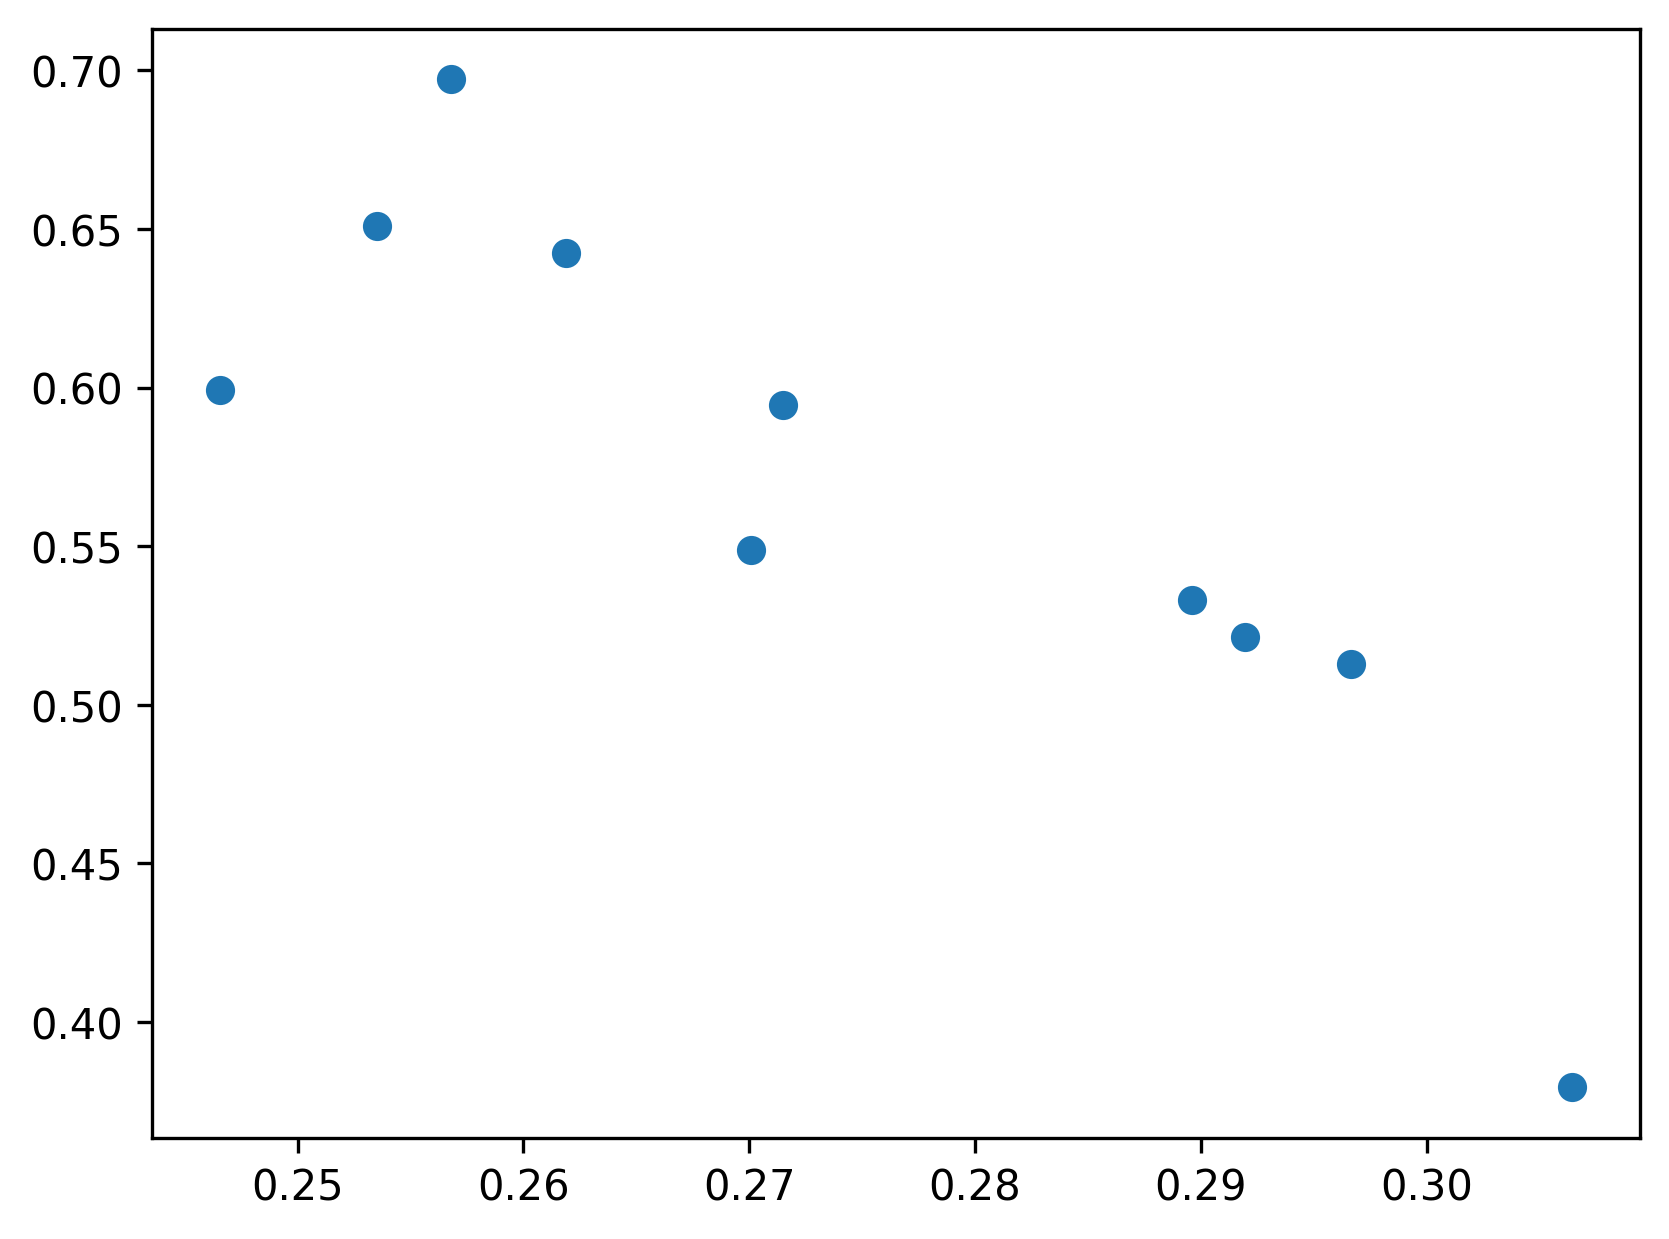

In [28]:
plt.scatter(incorrect_word_lens['incorrect_clean_word_len_mean'], incorrect_word_lens['acc'])

#### Statistics on Word Length and Accuracy

In [29]:
from scipy.stats import pearsonr
pearsonr(incorrect_word_lens['incorrect_clean_word_len_mean'], incorrect_word_lens['acc'])

PearsonRResult(statistic=-0.8689161494534806, pvalue=0.0010994379068981327)

In [30]:
pearsonr(edit_len_df.loc['0-shot']['incorrect_clean_word_len_mean'], incorrect_word_lens['acc'])

PearsonRResult(statistic=-0.8689161494534806, pvalue=0.0010994379068981327)

In [31]:
edit_len_df.loc['0-shot']['incorrect_clean_word_len_mean'].shape

(10,)

In [32]:
def acc_word_length_corr(df, col, by_strategy=False):
    merge_col = 'test' if not by_strategy else 'strategy'
    index = [merge_col, 'xshot', 'train']
    __df = df
    if by_strategy:
        __df = __df[__df['test'] == __df['train']]

    __df = __df.groupby(index+ ['setting'])[[col]].mean().round(3) * 100
    __df = __df.reset_index()
    __df = __df.merge(baseline_df, on=merge_col)
    __df['∆'] = (__df[col] - __df['ann']).round(3)

    __df = __df.pivot(index=index, columns=['setting'], values=['∆', col, 'ann'])\
        .sort_index()#
    
    if by_strategy:
        return __df.sort_index(level=0, sort_remaining=False, ascending=False)
    else:
        __df = __df.transpose().sort_values(('visual+phonetic+typo_full', '50-shot', 'visual+phonetic+typo_full'), ascending=False).sort_index(level=0, sort_remaining=False, ascending=False).transpose()
        __matching_df = __df[__df.index.get_level_values('test').isin(['phonetic', 'typo', 'visual']) & (__df.index.get_level_values('test') == __df.index.get_level_values('train'))]
        __df.loc['visual+phonetic+typo_full', '50-shot', 'mean'] = __matching_df.mean().transpose()

        __matching_df = __df[__df.index.get_level_values('test').isin(['phonetic', 'typo', 'visual']) & (__df.index.get_level_values('xshot') == '0-shot')]
        __df.loc['visual+phonetic+typo_full', '0-shot', 'mean'] = __matching_df.mean().transpose()
        return __df


acc_word_length_corr = result_df.pipe(acc_word_length_corr, 'match')
acc_word_length_corr.fillna('')

∆  \
setting                                                     falcon-7B   
test                      xshot   train                                 
phonetic                  0-shot  0shot                         -37.4   
                          50-shot phonetic                      -19.5   
                                  visual+phonetic+typo_full     -20.3   
                                  visual+typo_full              -20.6   
typo                      0-shot  0shot                         -30.7   
                          50-shot typo                          -14.9   
                                  visual+phonetic+typo_full     -15.5   
                                  visual+phonetic_full          -15.7   
visual                    0-shot  0shot                         -54.0   
                          50-shot phonetic+typo_full            -39.4   
                                  visual                        -39.1   
                                  visual+phonetic+typo_full     -39.0   
visual+phonetic+typo_full 50-shot visual+phonetic+typo_full     -22.7   
                                  mean                          -24.5   
                          0-shot  mean                          -40.7   

                                                                       \
setting                                                     llama2-7B   
test                      xshot   train                                 
phonetic                  0-shot  0shot                         -14.6   
                          50-shot phonetic                       -6.9   
                                  visual+phonetic+typo_full      -7.8   
                                  visual+typo_full               -8.9   
typo                      0-shot  0shot                          -9.1   
                          50-shot typo                           -6.3   
                                  visual+phonetic+typo_full      -6.2   
                                  visual+phonetic_full           -6.2   
visual                    0-shot  0shot                         -30.9   
                          50-shot phonetic+typo_full            -26.6   
                                  visual                        -25.8   
                                  visual+phonetic+typo_full     -26.1   
visual+phonetic+typo_full 50-shot visual+phonetic+typo_full     -11.6   
                                  mean                          -13.0   
                          0-shot  mean                          -18.2   

                                                                        \
setting                                                     llama2-13B   
test                      xshot   train                                  
phonetic                  0-shot  0shot                           -9.9   
                          50-shot phonetic                        -7.4   
                                  visual+phonetic+typo_full       -8.6   
                                  visual+typo_full                -9.7   
typo                      0-shot  0shot                           -6.4   
                          50-shot typo                            -5.1   
                                  visual+phonetic+typo_full       -4.9   
                                  visual+phonetic_full            -5.8   
visual                    0-shot  0shot                          -29.3   
                          50-shot phonetic+typo_full             -25.9   
                                  visual                         -25.1   
                                  visual+phonetic+typo_full      -25.4   
visual+phonetic+typo_full 50-shot visual+phonetic+typo_full      -11.5   
                                  mean                           -12.5   
                          0-shot  mean                           -15.2   

                                                                        \
setting                        

In [33]:
selected = result_table_df[[('ann', 'llama2-7B')] + [('∆', setting) for setting in result_df['setting'].unique()]]
selected.columns = pd.Series([c[0] if c[0] == 'ann' else c[1] for c in selected.columns])

ordered_cols = ['test', 'ann', 'xshot', 'train']
class_table = selected.reset_index()[['test', 'ann', 'xshot', 'train'] + [c for c in selected.columns if c not in ordered_cols]]
class_table = class_table[(class_table['train'] != 'visual+phonetic+typo_full') | (class_table['test'] == 'visual+phonetic+typo_full')]

def clean_dataset(s):
    if s == 'visual+phonetic+typo_full':
        return 'all classes'
    elif s.endswith('_full'):
        return s.replace('_full', '')
    elif s == '0shot':
        return 'zeroshot'
    return s
    
def setting(row):
    if row['train'] == 'zeroshot':
        return 'zeroshot'
    else:
        if row['train'] == 'mean':
            if row['xshot'] == '0-shot':
                return row['xshot'] + ' (mean)'
            else:
                return row['xshot'] + ' (mean same class)'
        return row['xshot'] + ' ' + row['train']

class_table['ann'] = class_table['ann'].apply(lambda x: round(x,1))

class_table['train'] = class_table['train'].apply(clean_dataset)
class_table['test'] = class_table['test'].apply(clean_dataset)
class_table = class_table[(class_table['train'] != 'all classes') | (class_table['test'] == 'all classes')]
class_table['setting'] = class_table.apply(setting, axis=1)
class_table = class_table.drop(['xshot', 'train'], axis=1)
class_table = class_table.set_index(['test', 'ann', 'setting']).sort_index(ascending=(True, False, True))

class_table = class_table.transpose().sort_values(class_table.transpose().columns[0], ascending=True).transpose()
class_table = class_table.rename({'text-bison-001': 'palm2-text-bison-001', 'gpt-3_5-turbo-0301': 'gpt 3.5-turbo-0301', 'gpt-3_5-turbo-0613': 'gpt 3.5-turbo-0613', 'gpt-4-1106-preview': 'gpt 4-1106-preview'}, axis=1)
class_table.columns = pd.MultiIndex.from_tuples([tuple(c.split('-', 1)) for c in class_table.columns])

class_table = class_table[[( 'falcon',             '7B'),
            ( 'falcon',            '40B'),
            ('mistral',             '7B'),
            ( 'llama2',             '7B'),
            ( 'llama2',            '13B'),
            ( 'llama2',            '70B'),
            (  'palm2', 'text-bison-001'),
            ('gpt 3.5',     'turbo-0301'),
            ('gpt 3.5',     'turbo-0613'),
            (  'gpt 4',   '1106-preview')]]

class_table

falcon       mistral llama2        \
                                               7B   40B      7B     7B   13B   
test        ann  setting                                                       
all classes 64.1 0-shot (mean)              -40.7 -11.3   -15.1  -18.2 -15.2   
                 50-shot (mean same class)  -24.5  -4.5   -11.8  -13.0 -12.5   
            63.6 50-shot all classes        -22.7  -1.6    -9.9  -11.6 -11.5   
phonetic    72.3 50-shot phonetic           -19.5  -1.1    -2.5   -6.9  -7.4   
                 50-shot visual+typo        -20.6  -3.4    -4.0   -8.9  -9.7   
                 zeroshot                   -37.4  -9.6    -8.1  -14.6  -9.9   
typo        56.9 50-shot typo               -14.9   1.1    -5.0   -6.3  -5.1   
                 50-shot visual+phonetic    -15.7  -0.9    -5.4   -6.2  -5.8   
                 zeroshot                   -30.7  -3.3    -6.9   -9.1  -6.4   
visual      63.2 50-shot phonetic+typo      -39.4 -14.3   -26.9  -26.6 -25.9   
                 50-shot visual             -39.1 -13.4   -28.0  -25.8 -25.1   
                 zeroshot                   -54.0 -20.9   -30.4  -30.9 -29.3   

                                                          palm2    gpt 3.5  \
                                             70B text-bison-001 turbo-0301   
test        ann  setting                                                     
all classes 64.1 0-shot (mean)             -13.6           -2.8       -4.3   
                 50-shot (mean same class)  -9.9            0.9       -4.4   
            63.6 50-shot all classes        -8.0            2.0       -2.0   
phonetic    72.3 50-shot phonetic           -8.9            3.2       -8.9   
                 50-shot visual+typo       -11.6            2.6       -8.9   
                 zeroshot                  -15.7            1.2       -8.7   
typo        56.9 50-shot typo               -2.2            2.5       -0.6   
                 50-shot visual+phonetic    -0.3            1.1       -0.7   
                 zeroshot                   -2.2           -0.9       -0.4   
visual      63.2 50-shot phonetic+typo     -18.3           -4.8       -4.0   
                 50-shot visual            -18.5           -3.1       -3.6   
                 zeroshot                  -22.9           -8.7       -3.7   

                                                             gpt 4  
                                           turbo-0613 1106-preview  
test        ann  setting                                            
all classes 64.1 0-shot (mean)                   -0.1          5.9  
                 50-shot (mean same class)        0.1          5.7  
            63.6 50-shot all classes              4.8          8.7  
phonetic    72.3 50-shot phonetic                -2.3         -5.2  
                 50-shot visual+typo             -2.3         -2.8  
                 zeroshot                        -2.4         -2.9  
typo        56.9 50-shot typo                     3.4         10.2  
                 50-shot visual+phonetic          3.4          9.7  
                 zeroshot                         3.0          9.3  
visual      63.2 50-shot phonetic+typo           -0.5         10.2  
                 50-shot visual                  -0.7         12.1  
                 zeroshot                        -1.0         11.3

In [35]:
strategies = {
    'phonetic': ['anthro_phonetic', 'zeroe_phonetic', 'phonee'],
    'typo': ['anthro_typo', 'zeroe_typo', 'zeroe_noise'],
    'visual':['dces', 'ices', 'legit_extended']
}

keys = [(v, k) for k, vs in strategies.items() for v in vs]


attack_lvl_table = result_df.pipe(acc_table, 'match', by_strategy=True)
attack_lvl_table.droplevel('xshot').loc[keys][[('match', model) for model in ['falcon-40B', 'falcon-7B', 'llama2-13B', 'llama2-70B', 'llama2-7B', 'mistral-7B']]]

match                                            \
setting                  falcon-40B falcon-7B llama2-13B llama2-70B llama2-7B   
strategy        train                                                           
anthro_phonetic phonetic       83.2      62.2       74.1       73.1      77.3   
zeroe_phonetic  phonetic       56.5      42.3       53.4       55.3      50.0   
phonee          phonetic       69.0      47.2       62.5       61.9      57.9   
anthro_typo     typo           50.5      36.9       43.9       47.6      43.6   
zeroe_typo      typo           66.0      49.8       62.7       63.5      59.6   
zeroe_noise     typo           61.7      36.8       49.7       58.4      47.0   
dces            visual         60.9      28.3       50.8       56.4      44.7   
ices            visual         37.9      15.7       26.3       34.3      22.5   
legit_extended  visual         42.3      21.6       32.7       36.3      34.2   

                                     
setting                  mistral-7B  
strategy        train                
anthro_phonetic phonetic       81.1  
zeroe_phonetic  phonetic       53.4  
phonee          phonetic       62.9  
anthro_typo     typo           44.6  
zeroe_typo      typo           61.4  
zeroe_noise     typo           47.2  
dces            visual         41.4  
ices            visual         22.0  
legit_extended  visual         31.4

In [36]:
attack_lvl_table.droplevel('xshot').loc[keys][[('match', model) for model in ['text-bison-001', 'gpt-3_5-turbo-0301', 'gpt-3_5-turbo-0613', 'gpt-4-1106-preview']]]

match                                        \
setting                  text-bison-001 gpt-3_5-turbo-0301 gpt-3_5-turbo-0613   
strategy        train                                                           
anthro_phonetic phonetic           85.3               69.3               78.9   
zeroe_phonetic  phonetic           57.5               52.4               57.3   
phonee          phonetic           76.8               68.2               70.2   
anthro_typo     typo               50.4               44.6               47.5   
zeroe_typo      typo               65.5               64.1               69.5   
zeroe_noise     typo               63.7               72.9               75.8   
dces            visual             79.7               83.3               85.8   
ices            visual             41.8               45.7               48.6   
legit_extended  visual             49.3               48.9               51.6   

                                             
setting                  gpt-4-1106-preview  
strategy        train                        
anthro_phonetic phonetic               71.0  
zeroe_phonetic  phonetic               56.1  
phonee          phonetic               74.6  
anthro_typo     typo                   56.6  
zeroe_typo      typo                   73.1  
zeroe_noise     typo                   81.3  
dces            visual                 92.1  
ices            visual                 61.1  
legit_extended  visual                 65.4

In [37]:
tuple(attack_lvl_table[('ann', 'falcon-40B')].droplevel('xshot').droplevel('train')[['anthro_phonetic', 'zeroe_phonetic', 'phonee']])

(86.3, 86.3, 86.3, 86.3, 50.0, 50.0, 50.0, 50.0, 74.3, 74.3, 74.3, 74.3)

In [39]:
attack_lvl_table.columns

MultiIndex([(    '∆',         'falcon-40B'),
            (    '∆',          'falcon-7B'),
            (    '∆', 'gpt-3_5-turbo-0301'),
            (    '∆', 'gpt-3_5-turbo-0613'),
            (    '∆', 'gpt-4-1106-preview'),
            (    '∆',         'llama2-13B'),
            (    '∆',         'llama2-70B'),
            (    '∆',          'llama2-7B'),
            (    '∆',         'mistral-7B'),
            (    '∆',     'text-bison-001'),
            ('match',         'falcon-40B'),
            ('match',          'falcon-7B'),
            ('match', 'gpt-3_5-turbo-0301'),
            ('match', 'gpt-3_5-turbo-0613'),
            ('match', 'gpt-4-1106-preview'),
            ('match',         'llama2-13B'),
            ('match',         'llama2-70B'),
            ('match',          'llama2-7B'),
            ('match',         'mistral-7B'),
            ('match',     'text-bison-001'),
            (  'ann',         'falcon-40B'),
            (  'ann',          'falcon-7B'),
          

In [41]:
attack_bests = {}

strategies = {
    'phonetic': [('anthro_phonetic', "ANTHRO Phonetic"), ('zeroe_phonetic', "Zeroé Phonetic"), ('phonee', "PhoneE")],
    'typo': [('anthro_typo', 'ANTHRO Typo'), ('zeroe_typo', 'Zeroé Typo'), ('zeroe_noise', 'Zeroé Nose')],
    'visual':[('dces', 'DCES'), ('ices', 'ICES'), ('legit_extended', 'LEGIT')]
}

attacks = strategies['phonetic']
attacks_raw = [a[0] for a in attacks]
attacks_pretty = [a[1] for a in attacks]

clazz_attack_level = attack_lvl_table.loc[:, :, 'phonetic']
propriatary_df  = [('match', col) for col in ['text-bison-001', 'gpt-3_5-turbo-0301', 'gpt-3_5-turbo-0613', 'gpt-4-1106-preview']]
open_df  = [('match', col) for col in ['falcon-40B', 'falcon-7B', 'llama2-13B', 'llama2-70B', 'llama2-7B', 'mistral-7B']]
pro_abs = clazz_attack_level[clazz_attack_level.index.get_level_values('strategy').isin(attacks_raw)][propriatary_df]
open_abs = clazz_attack_level[clazz_attack_level.index.get_level_values('strategy').isin(attacks_raw)][open_df]

pro_mapping = pro_abs.apply(lambda x: pd.Series([x.idxmax()[1], x.max()], index=['Max_Column', 'Max_Value']), axis=1).droplevel('xshot')
open_mapping = open_abs.apply(lambda x: pd.Series([x.idxmax()[1], x.max()], index=['Max_Column', 'Max_Value']), axis=1).droplevel('xshot')

display(pro_mapping)
display([open_mapping.loc[attack] for attack in attacks_raw])

,Max_Column,Max_Value
strategy,,
zeroe_phonetic,text-bison-001,57.5
phonee,text-bison-001,76.8
anthro_phonetic,text-bison-001,85.3


[Max_Column    falcon-40B
 Max_Value           83.2
 Name: anthro_phonetic, dtype: object,
 Max_Column    falcon-40B
 Max_Value           56.5
 Name: zeroe_phonetic, dtype: object,
 Max_Column    falcon-40B
 Max_Value           69.0
 Name: phonee, dtype: object]

### Visualize By Class

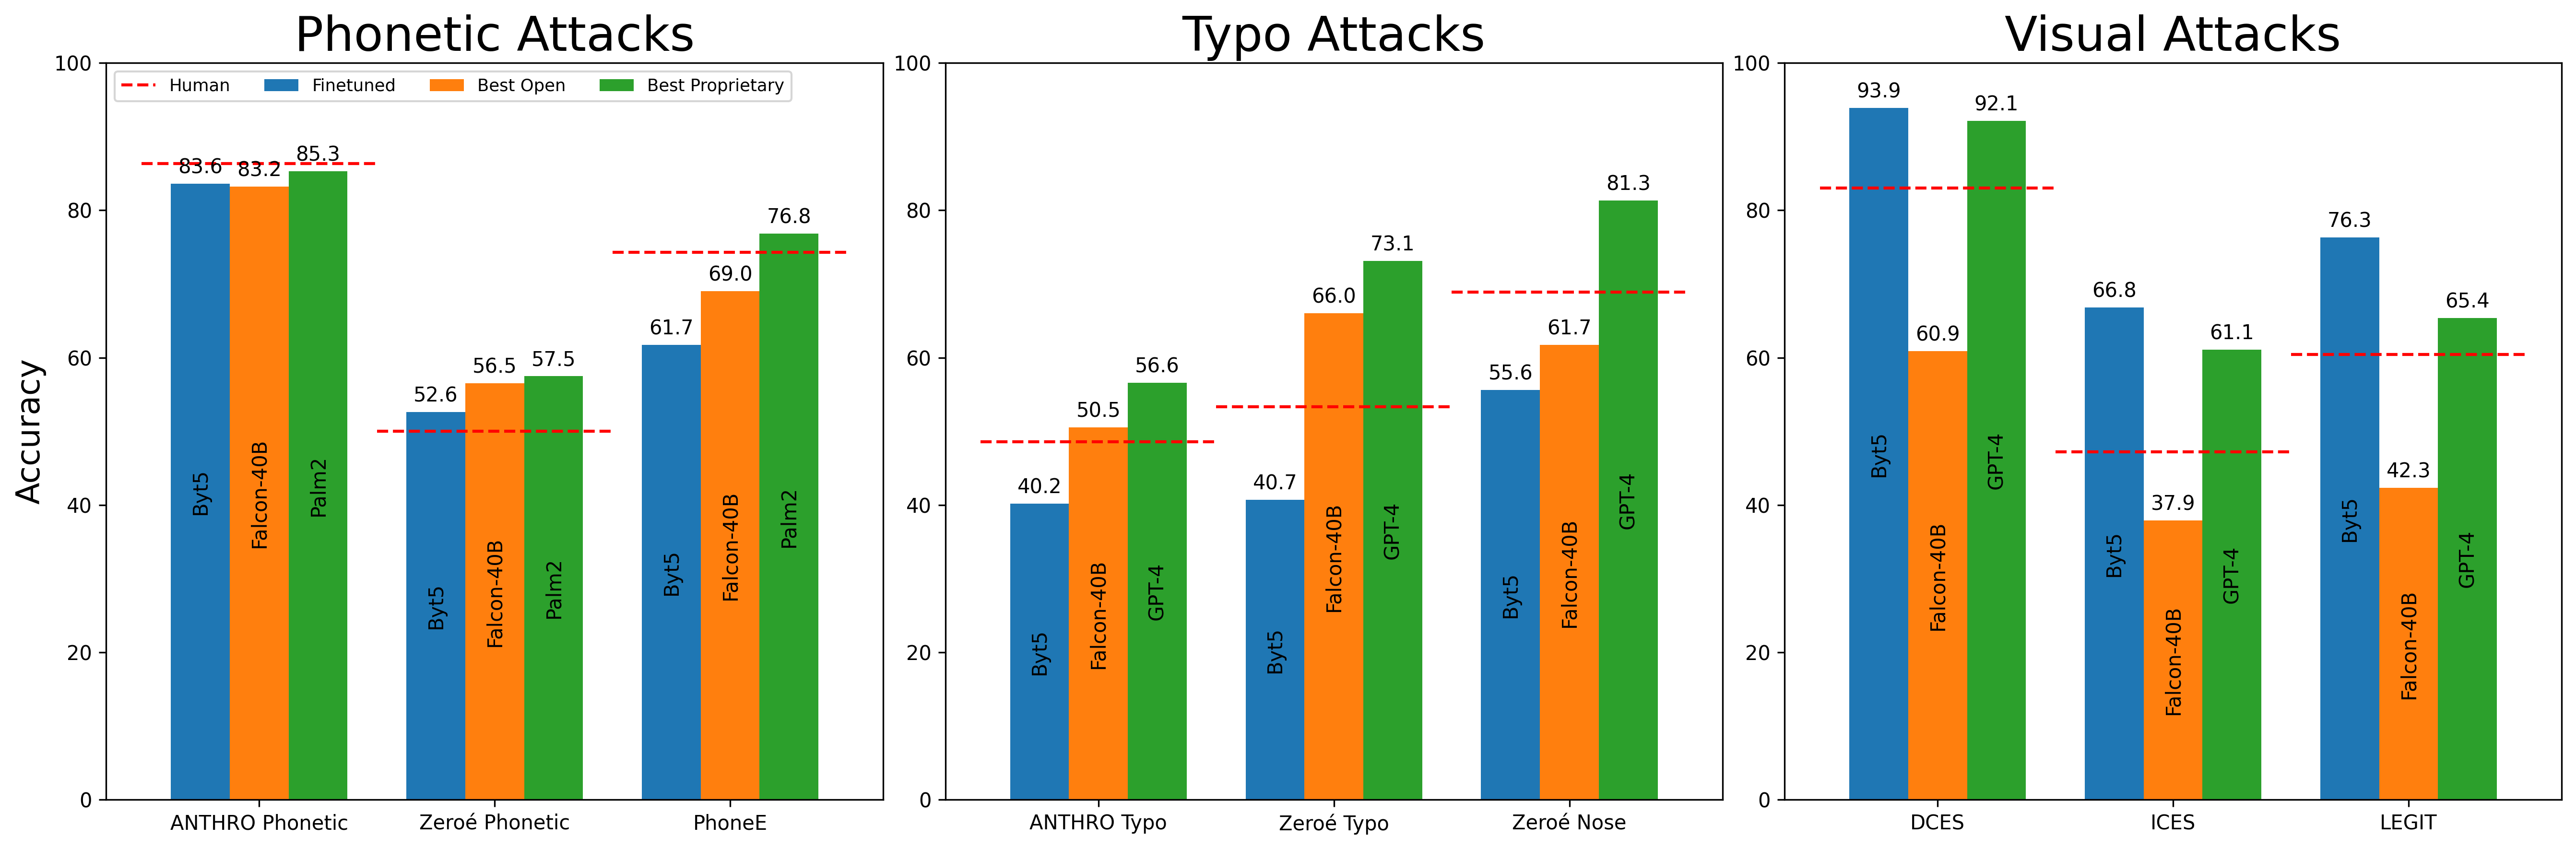

In [45]:
byt5s = {
    'phonetic': [83.6, 52.6, 61.7],
    'typo': [40.2, 40.7, 55.6],
    'visual': [93.9, 66.8, 76.3]
}

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

def pretty_name(model):
    if model.startswith('gpt-4'):
        return 'GPT-4'
    elif model.startswith('gpt-3'):
        return 'GPT_3.5'
    elif model.startswith('text-bison'):
        return 'Palm2'
    else:
        return model.title()

for j, (ax, clazz) in enumerate(zip(axs, ['phonetic', 'typo', 'visual'])):

    attacks = strategies[clazz]
    attacks_raw = [a[0] for a in attacks]
    attacks_pretty = [a[1] for a in attacks]

    clazz_attack_level = attack_lvl_table.loc[:, :, clazz]
    propriatary_df  = [('match', col) for col in ['text-bison-001', 'gpt-3_5-turbo-0301', 'gpt-3_5-turbo-0613', 'gpt-4-1106-preview']]
    open_df  = [('match', col) for col in ['falcon-40B', 'falcon-7B', 'llama2-13B', 'llama2-70B', 'llama2-7B', 'mistral-7B']]
    pro_abs = clazz_attack_level[clazz_attack_level.index.get_level_values('strategy').isin(attacks_raw)][propriatary_df]
    open_abs = clazz_attack_level[clazz_attack_level.index.get_level_values('strategy').isin(attacks_raw)][open_df]

    pro_mapping = pro_abs.apply(lambda x: pd.Series([x.idxmax()[1], x.max()], index=['Max_Column', 'Max_Value']), axis=1).droplevel('xshot')
    open_mapping = open_abs.apply(lambda x: pd.Series([x.idxmax()[1], x.max()], index=['Max_Column', 'Max_Value']), axis=1).droplevel('xshot')

    accuracies = {
        'Finetuned': [('Byt5', p) for p in byt5s[clazz]],
        'Best Open': [open_mapping.loc[attack] for attack in attacks_raw],
        'Best Proprietary': [pro_mapping.loc[attack] for attack in attacks_raw],
    }

    all_ann = attack_lvl_table[('ann', 'falcon-40B')].droplevel('xshot').droplevel('train')
    human = tuple(all_ann[attacks_raw].drop_duplicates().dropna())

    x = np.arange(len(attacks))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    for attribute, measurement in accuracies.items():
        offset = width * multiplier
        keys = [pretty_name(m[0]) for m in measurement]
        vals = [m[1] for m in measurement]
        rects = ax.bar(x + offset, vals, width, label=pretty_name(attribute))
        ax.bar_label(rects, fmt='%.1f', padding=3)
        ax.bar_label(rects, labels=keys, label_type="center", rotation=90)
        multiplier += 1

    # draw horizontal lines for human accuracy
    for i, hacc in enumerate(human):
        if not i:
            ax.hlines(y=hacc, xmin=x[i] - width, xmax=x[i] + 3*width, label='Human', linestyle='--', color='r')
        else:
            ax.hlines(y=hacc, xmin=x[i] - width, xmax=x[i] + 3*width, linestyle='--', color='r')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    
    ax.set_xticks(x + width, attacks_pretty)
    ax.set_title(f'{clazz.title()} Attacks', size=24)
    if j == 0:
        ax.legend(loc='upper left', ncols=4, prop={'size': 8.5})
        ax.set_ylabel('Accuracy', size=16)
    ax.set_ylim(0, 100)

plt.tight_layout()
plt.subplots_adjust(wspace=.08)
plt.show()


In [53]:
attack_lvl_delta = attack_lvl_table['∆'].rename({'text-bison-001': 'palm2-bison', 'gpt-3_5-turbo-0301': 'gpt 3.5-0301', 'gpt-3_5-turbo-0613': 'gpt 3.5-0613', 'gpt-4-1106-preview': 'gpt 4-1106'}, axis=1)
attack_lvl_delta.columns = pd.MultiIndex.from_tuples([tuple(c.split('-', 1)) for c in attack_lvl_delta.columns])

attack_lvl_delta = attack_lvl_delta[[
            ( 'falcon',             '7B'),
            ( 'falcon',            '40B'),
            ('mistral',             '7B'),
            ( 'llama2',             '7B'),
            ( 'llama2',            '13B'),
            ( 'llama2',            '70B'),
            (  'palm2',          'bison'),
            ('gpt 3.5',           '0301'),
            ('gpt 3.5',           '0613'),
            (  'gpt 4',           '1106')]]
attack_lvl_delta = attack_lvl_delta.transpose()

attack_lvl_delta.columns = attack_lvl_delta.columns.droplevel('xshot').droplevel('train')
attack_lvl_delta = attack_lvl_delta.rename({'strategy': 'size'}, axis=1)
cols = ['anthro_phonetic', 'zeroe_phonetic', 'phonee', 'anthro_typo', 'zeroe_typo', 'zeroe_noise', 'dces', 'ices', 'legit_extended']
for col in cols:
    attack_lvl_delta[col] = attack_lvl_delta[col].round(0)
    attack_lvl_delta[col] = attack_lvl_delta[col].apply(lambda x: str(x) if len(x) == 1 and abs(x) < 10 else str(x).split('.')[0])

In [ ]:
for line in attack_lvl_delta[cols].round(0).to_latex().split('\n'):
    print(line)

In [55]:
result_df.pipe(acc_table, 'nan_match').fillna('')

∆  \
setting                                                     falcon-7B   
test                      xshot   train                                 
phonetic                  0-shot  0shot                         -37.4   
                          50-shot phonetic                      -19.5   
                                  visual+phonetic+typo_full     -20.3   
                                  visual+typo_full              -20.6   
typo                      0-shot  0shot                         -30.7   
                          50-shot typo                          -14.9   
                                  visual+phonetic+typo_full     -15.5   
                                  visual+phonetic_full          -15.7   
visual                    0-shot  0shot                         -54.0   
                          50-shot phonetic+typo_full            -39.4   
                                  visual                        -39.1   
                                  visual+phonetic+typo_full     -39.0   
visual+phonetic+typo_full 50-shot visual+phonetic+typo_full     -22.7   
                                  mean                          -24.5   
                          0-shot  mean                          -40.7   

                                                                        \
setting                                                     llama2-13B   
test                      xshot   train                                  
phonetic                  0-shot  0shot                           -9.9   
                          50-shot phonetic                        -7.3   
                                  visual+phonetic+typo_full       -8.6   
                                  visual+typo_full                -9.6   
typo                      0-shot  0shot                           -6.2   
                          50-shot typo                            -4.8   
                                  visual+phonetic+typo_full       -4.7   
                                  visual+phonetic_full            -5.8   
visual                    0-shot  0shot                          -27.5   
                          50-shot phonetic+typo_full             -25.4   
                                  visual                         -24.8   
                                  visual+phonetic+typo_full      -25.2   
visual+phonetic+typo_full 50-shot visual+phonetic+typo_full      -11.3   
                                  mean                           -12.3   
                          0-shot  mean                           -14.5   

                                                                       \
setting                                                     llama2-7B   
test                      xshot   train                                 
phonetic                  0-shot  0shot                         -14.6   
                          50-shot phonetic                       -6.8   
                                  visual+phonetic+typo_full      -7.6   
                                  visual+typo_full               -8.6   
typo                      0-shot  0shot                          -9.1   
                          50-shot typo                           -6.3   
                                  visual+phonetic+typo_full      -6.1   
                                  visual+phonetic_full           -6.2   
visual                    0-shot  0shot                         -30.9   
                          50-shot phonetic+typo_full            -26.4   
                                  visual                        -25.7   
                                  visual+phonetic+typo_full     -25.8   
visual+phonetic+typo_full 50-shot visual+phonetic+typo_full     -11.3   
                                  mean                          -12.9   
                          0-shot  mean                          -18.2   

                                                                        \
setting                        